# Lab 4: Convolutional Neural Networks



## Part 0: Import Modules, Define Useful Functions

In [0]:
!pip uninstall -y tensorflow

In [0]:
!pip install -U tensorflow-gpu==2.0.0-beta1

Requirement already up-to-date: tensorflow==2.0.0-beta1 in /usr/local/lib/python3.6/dist-packages (2.0.0b1)


In [0]:
import sklearn

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

for plotting grayscale and colour images.

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## Part 1: The Convolution Layer

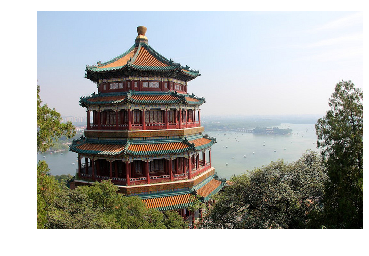

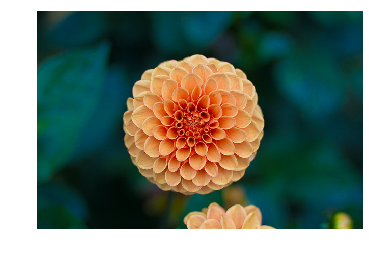

In [0]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

plot_color_image(china)
plt.show()
plot_color_image(flower)
plt.show()

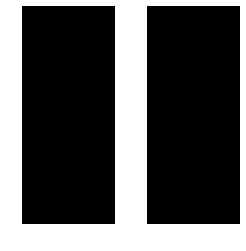

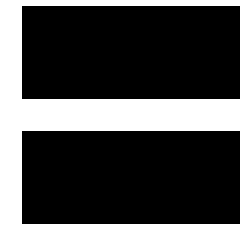

In [0]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

``` tf.nn.conv2d() ```
*   ```images```: mini-batch input (image #, height, width, channels)
*   ```filters```: set of filters/kernels (height, width, channels, filter #)
* ```strides```: simply set to a number, or (1, s_h, s_w, 1). The first and last '1's are batch strides and channel strides
* ```padding```: see figure below

![Padding Explanation](https://drive.google.com/uc?id=1VCeJIdlbTJ4EgkAJ1dYl1e4NUSgm8J-Q)

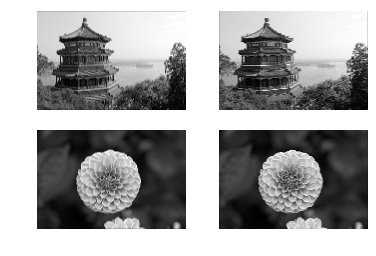

In [0]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

Saving figure china_original


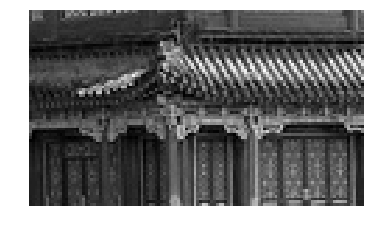

Saving figure china_vertical


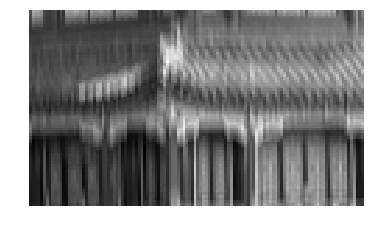

Saving figure china_horizontal


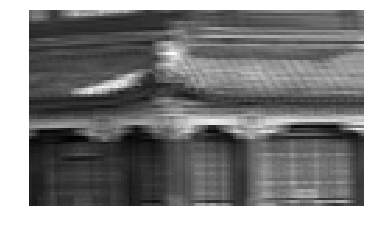

In [0]:
def crop(images):
  return images[150:220, 130:250]

plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

You can use the keras 2D convolution layer API instead.

In [0]:
def vertical_kernel_initializer(shape_, dtype=None):
  kernel = np.zeros(shape=shape_, dtype=np.float32)
  kernel[:, shape_[0] // 2, :, 0] = 1
  return kernel

In [0]:
conv = keras.layers.Conv2D(filters=32, kernel_size=7, 
                           kernel_initializer=vertical_kernel_initializer, 
                           strides=1, padding="SAME", activation="relu")

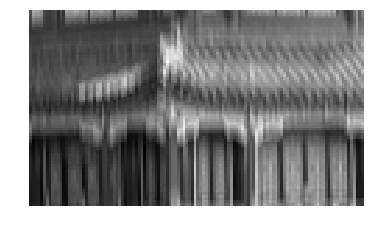

In [0]:
keras_output = conv(images)
plot_image(crop(keras_output[0, :, :, 0]))

## Part 2: The Pooling Layer

### Max Pooling

In [0]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [0]:
cropped_images = np.array([crop(image) for image in images])
output = max_pool(cropped_images)

Saving figure china_max_pooling


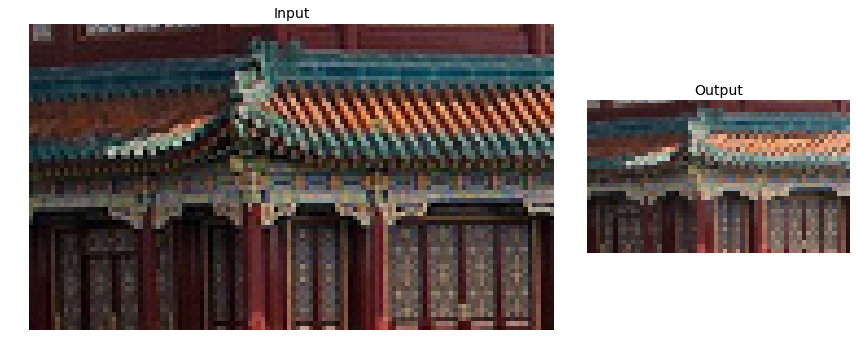

In [0]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

### Depth-wise Pooling

In [0]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [0]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

Alternatively, we can use a Lambda layer. A Lambda layer is like the python Lambda function: it is arbitrary and can be defined by the user themselves. Normally, we define a function in python using the keyword ```def```. You can define a nameless function using the ```lambda``` keyword.

In [0]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

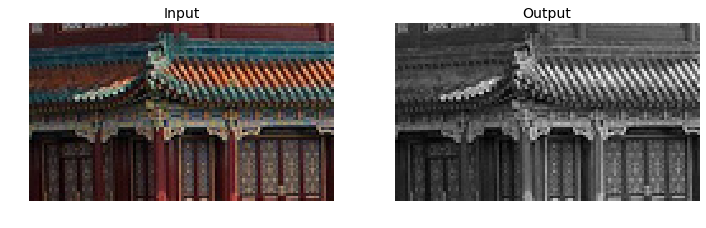

In [0]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

### Average Pooling

In [0]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [0]:
output_avg = avg_pool(cropped_images)

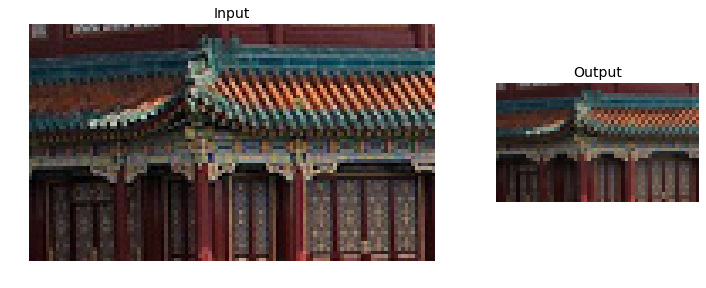

In [0]:

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### Global Average Pooling

In [0]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: id=104, shape=(2, 3), dtype=float64, numpy=
array([[0.27887768, 0.2250719 , 0.20967274],
       [0.51288515, 0.45951634, 0.33423483]])>

Again, you can use the Lambda layer to define global average pooling, like so:

In [0]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: id=108, shape=(2, 3), dtype=float64, numpy=
array([[0.27887768, 0.2250719 , 0.20967274],
       [0.51288515, 0.45951634, 0.33423483]])>

## Assignment: Performing Fashion MNIST Classification with CNN

Now that you've learned about CNNs, let's try it on the fashion MNIST dataset to see how it compares to MLPs.

You should be well-equipped for this assignment, other than the hyperparameters. Remember to ask questions as soon as you run into any problems.

In [0]:
# Write code here: